In [109]:
import os
import shutil
import glob
import re
from tqdm import tqdm

import numpy as np
import pylab
import matplotlib.pyplot as plt
from shenfun import *
import torch

# NS - buoyancy factor

source: https://physicsbaseddeeplearning.org/overview-ns-forw.html

In [1]:
DT = 1
NU = 0.0001
res = [64,64]
radius = 4

INFLOW = CenteredGrid(Sphere(center=tensor([res[0]//2, radius], channel(vector='x,y')), radius=radius), extrapolation.BOUNDARY, x=res[0], y=res[1], bounds=Box(x=(0,res[0]),y=(0,res[1])))
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=res[0]//2, y=res[1]//2, bounds=Box(x=(0,res[0]),y=(0,res[1])))  # sampled at cell centers
velocity = StaggeredGrid(0, extrapolation.ZERO, x=res[0]//2, y=res[1]//2, bounds=Box(x=(0,res[0]),y=(0,res[1])))  # sampled in staggered form at face centers 

def step(velocity, smoke, pressure, dt=1.0, buoyancy_factor=1.0, with_inflow=True):
    if with_inflow:
        smoke = advect.semi_lagrangian(smoke, velocity, dt) + INFLOW
    else:
        smoke = advect.semi_lagrangian(smoke, velocity, dt)
        
    buoyancy_force = (smoke * (0, buoyancy_factor)).at(velocity)  # resamples smoke to velocity sample points
    velocity = advect.semi_lagrangian(velocity, velocity, dt) + dt * buoyancy_force
    velocity = diffuse.explicit(velocity, NU, dt)
    velocity, pressure = fluid.make_incompressible(velocity)
    return velocity, smoke, pressure

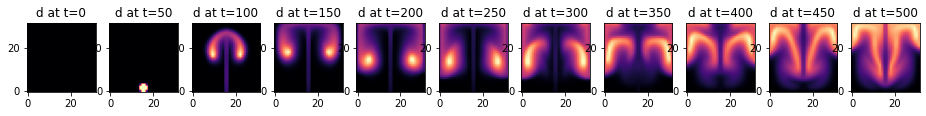

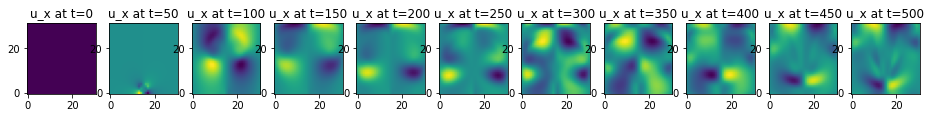

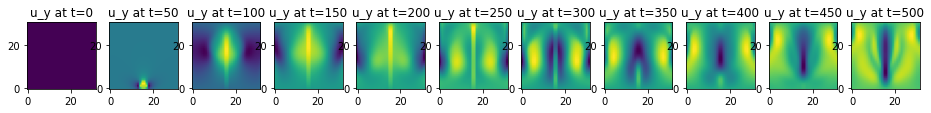

In [2]:
# Advection-Diffusion step
n_step = 500
buoyancy_f = 1
steps = [[ smoke.values, velocity.values.vector[0], velocity.values.vector[1] ]]
pressure = None

for time_step in range(n_step):
    if time_step > 0:
        velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT, buoyancy_factor=buoyancy_f, with_inflow=False)
    else:
        velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT, buoyancy_factor=buoyancy_f, with_inflow=True)
        
    if time_step % (n_step // 10) == 0:
        steps.append( [smoke.values, velocity.values.vector[0], velocity.values.vector[1]] )

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][0].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"d at t={i*(n_step // 10)}")
    
# Velocity fields
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][1].numpy('y,x'), origin='lower', cmap='viridis')
    axes[i].set_title(f"u_x at t={i*(n_step // 10)}")
    
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][2].numpy('y,x'), origin='lower', cmap='viridis')
    axes[i].set_title(f"u_y at t={i*(n_step // 10)}")

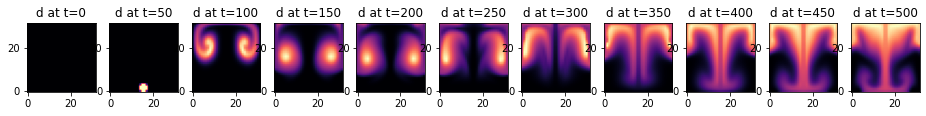

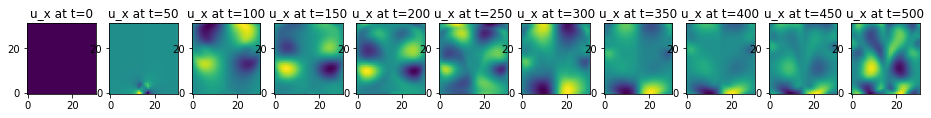

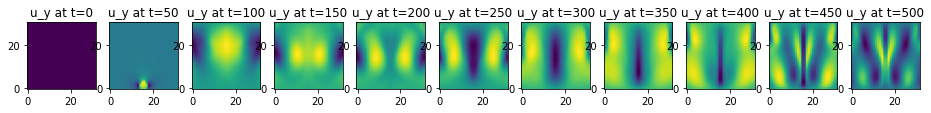

In [2]:
# Advection-Diffusion step
n_step = 500
buoyancy_f = 25
steps = [[ smoke.values, velocity.values.vector[0], velocity.values.vector[1] ]]
pressure = None

for time_step in range(n_step):
    if time_step > 0:
        velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT, buoyancy_factor=buoyancy_f, with_inflow=False)
    else:
        velocity, smoke, pressure = step(velocity, smoke, pressure, dt=DT, buoyancy_factor=buoyancy_f, with_inflow=True)
        
    if time_step % (n_step // 10) == 0:
        steps.append( [smoke.values, velocity.values.vector[0], velocity.values.vector[1]] )

fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][0].numpy('y,x'), origin='lower', cmap='magma')
    axes[i].set_title(f"d at t={i*(n_step // 10)}")
    
# Velocity fields
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][1].numpy('y,x'), origin='lower', cmap='viridis')
    axes[i].set_title(f"u_x at t={i*(n_step // 10)}")
    
fig, axes = pylab.subplots(1, len(steps), figsize=(16, 5))
for i in range(len(steps)):
    axes[i].imshow(steps[i][2].numpy('y,x'), origin='lower', cmap='viridis')
    axes[i].set_title(f"u_y at t={i*(n_step // 10)}")

# Rayleigh-Benard convection

In [117]:
def mkdir(folder):
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

def generate_rayleigh_benard_data(Ra=10000, end_time=60, save_dir="./datasets/rayleigh_benard"):
    def compute_convection(u, H):
        up = u.backward(padding_factor=1.5).v
        curl = Curl().backward(padding_factor=1.5)
        H[0] = W_DFp.forward(-curl*up[1])
        H[1] = W_DFp.forward(curl*up[0])
        H.mask_nyquist(mask)
        return H

    def compute_v(rk):
        v00[:] = u_[1, :, 0].real
        h1[:] = H_[1, :, 0].real
        u_[1] = 1j*dudx()/K[1]
        pdes1d['v0'].compute_rhs(rk)
        u_[1, :, 0] = pdes1d['v0'].solve_step(rk)

    def compute_uT(u_, T_, uT_):
        up = u_.backward(padding_factor=1.5)
        Tp = T_.backward(padding_factor=1.5)
        uT_ = BDp.forward(up*Tp, uT_)
        return uT_

    N, M = 128, 128
    family = 'Chebyshev'
    VB = FunctionSpace(N, family, bc=(0, 0, 0, 0))
    VD = FunctionSpace(N, family, bc=(0, 0))
    VW = FunctionSpace(N, family)
    VT = FunctionSpace(N, family, bc=(1, 0))
    VF = FunctionSpace(M, 'F', dtype='d')

    W_BF = TensorProductSpace(comm, (VB, VF))    # Wall-normal velocity
    W_DF = TensorProductSpace(comm, (VD, VF))    # Streamwise velocity
    W_WF = TensorProductSpace(comm, (VW, VF))    # No bc
    W_TF = TensorProductSpace(comm, (VT, VF))    # Temperature
    BD = VectorSpace([W_BF, W_DF])   # Velocity vector
    DD = VectorSpace([W_DF, W_DF])   # Convection vector
    W_DFp = W_DF.get_dealiased(padding_factor=1.5)
    BDp = BD.get_dealiased(padding_factor=1.5)

    u_  = Function(BD)     # Velocity vector, two components
    T_  = Function(W_TF)   # Temperature
    H_  = Function(DD)     # Convection vector
    uT_ = Function(BD)     # u times T

    # Specify viscosity and time step size using dimensionless Ra and Pr
    Ra = Ra #Critical=1693
    Pr = 0.7
    nu = np.sqrt(Pr/Ra)
    kappa = 1./np.sqrt(Pr*Ra)
    dt = 0.025

    # Choose timestepper and create instance of class
    PDE = IMEXRK3 # IMEX222, IMEXRK443
    v = TestFunction(W_BF) # The space we're solving for u in

    pdes = {
        'u': PDE(v,                              # test function
                div(grad(u_[0])),               # u
                lambda f: nu*div(grad(f)),      # linear operator on u
                [Dx(Dx(H_[1], 0, 1), 1, 1)-Dx(H_[0], 1, 2), Dx(T_, 1, 2)],
                dt=dt,
                solver=chebyshev.la.Biharmonic if family == 'Chebyshev' else la.SolverGeneric1ND,
                latex=r"\frac{\partial \nabla^2 u}{\partial t} = \nu \nabla^4 u + \frac{\partial^2 N_y}{\partial x \partial y} - \frac{\partial^2 N_x}{\partial y^2}")
    }
    pdes['u'].assemble()

    # Get a mask for setting Nyquist frequency to zero
    mask = W_DF.get_mask_nyquist()
    Curl = Project(curl(u_), W_WF) # Instance used to compute curl

    f = dudx = Project(Dx(u_[0], 0, 1), W_DF)

    K = W_BF.local_wavenumbers(scaled=True)
    K[1][0, 0] = 1 # to avoid division by zero. This component is computed later anyway.
    u_[1] = 1j*dudx()/K[1]

    v00 = Function(VD)
    v0 = TestFunction(VD)
    h1 = Function(VD) # convection equal to H_[1, :, 0]
    pdes1d = {
        'v0': PDE(v0,
                v00,
                lambda f: nu*div(grad(f)),
                -Expr(h1),
                dt=dt,
                solver=chebyshev.la.Helmholtz if family == 'Chebyshev' else la.Solver,
                latex=r"\frac{\partial v}{\partial t} = \nu \frac{\partial^2 v}{\partial x^2} - N_y "),
    }
    pdes1d['v0'].assemble()

    uT_ = Function(BD)
    q = TestFunction(W_TF)
    pdes['T'] = PDE(q,
                    T_,
                    lambda f: kappa*div(grad(f)),
                    -div(uT_),
                    dt=dt,
                    solver=chebyshev.la.Helmholtz if family == 'Chebyshev' else la.SolverGeneric1ND,
                    latex=r"\frac{\partial T}{\partial t} = \kappa \nabla^2 T - \nabla \cdot \vec{u}T")
    pdes['T'].assemble()

    # Time-stepping run
    T_b = Array(W_TF)
    X = W_TF.local_mesh(True)
    #T_b[:] = 0.5*(1-X[0]) + 0.001*np.random.randn(*T_b.shape)*(1-X[0])*(1+X[0])
    T_b[:] = 0.5*(1-X[0]+0.25*np.sin(np.pi*X[0]))+0.001*np.random.randn(*T_b.shape)*(1-X[0])*(1+X[0])
    T_ = T_b.forward(T_)
    T_.mask_nyquist(mask)
    t = 0
    tstep = 0
    end_time = end_time

    save_path = os.path.join(save_dir, str(Ra))
    save_idx = 0
    mkdir(save_path)

    while t < end_time-1e-8:
        for rk in range(PDE.steps()):
            compute_convection(u_, H_)
            compute_uT(u_, T_, uT_)
            pdes['u'].compute_rhs(rk)
            pdes['T'].compute_rhs(rk)
            pdes['u'].solve_step(rk)
            compute_v(rk)
            pdes['T'].solve_step(rk)
        t += dt
        tstep += 1
        if tstep % ((1/dt)//2) == 0:
            data = T_.backward()
            data = ((data - data.min()) * (1/(data.max() - data.min()) * 255)).astype('uint8')
            plt.imsave(os.path.join(save_path, f"{int(save_idx)}.jpg"), data, cmap="coolwarm")
            save_idx += 1


In [132]:
save_dir = "../data/rayleigh_benard"
Ras = np.arange(500,10100,100)
for Ra in tqdm(Ras):
    generate_rayleigh_benard_data(Ra=Ra, end_time=60, save_dir=save_dir)

100%|██████████| 96/96 [3:11:13<00:00, 119.51s/it]  


In [127]:
# Save as a moving image in time
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

output_dir = "../docs"
all_imgs = list()

ra = 2000
imgs_path = glob.glob(os.path.join(save_dir, f"{ra}/*jpg"))
imgs_path.sort(key=alphanum_key)

for img_path in imgs_path:
    all_imgs.append(Image.open(img_path))

all_imgs[0].save(os.path.join(output_dir, f"rayleigh_benard_{ra}.gif"), save_all=True, append_images=all_imgs[1:], optimize=False, duration=100, loop=0)